# Normalizing flows in PyTorch (part 2)
## Different types of flows

Here, we expand on the idea of implementing *Normalizing Flows* [[1](#reference1),[2](#reference)] based on `torch.distributions` that we discussed in the previous tutorial. The main idea is still to *transform* a simple probability distribution through a sequence of invertible nonlinear transforms. In this second part, we will focus on more advanced types of normalizing flows recently introduced. 

In this tutorial we will cover
1. A [quick recap](#recap) of the concepts previously introduced
2. How to implement the [radial flow](#radial) from the original paper
3. Different types of [invertible generative flows](#invertible) (PReLU, BatchNorm) that can be developed
4. Defining a [multi-layer perceptron-like flow](#advanced) based on these components

**Note**: Once again, this tutorial is a work-in-progress, so I would gladly take any feedback, update or suggestions. If you have any ideas, please contact me (https://esling.github.io/)

<a id="recap"></a>
## Quick recap

#### Normalizing flows

Normalizing flow allow to transform a probability distribution, through a series of *change of variable*. For a single transform, if $\mathbf{z}\in\mathcal{R}^d$ be a random variable with distribution $q(\mathbf{z})$ and $f:\mathcal{R}^d\rightarrow\mathcal{R}^d$ an invertible smooth mapping, we obtain the following transformation

$$
q(\mathbf{z}')=q(\mathbf{z})\left|\text{ det}\frac{\delta f^{−1}}{\delta \mathbf{z}'}\right| = q(\mathbf{z})\left|\text{ det}\frac{\delta f}{\delta \mathbf{z}}\right|^{−1}
\tag{1}
$$

Now, if we start with a random vector $\mathbf{z}_0$ with distribution $q_0$, we can apply a series of mappings $f_i$, $i \in 1,\cdots,k$ with $k\in\mathcal{N}^{+}$ and obtain a normalizing flow. Hence, if we apply $k$ normalizing flows, we obtain a chain of change of variables

$$
\mathbf{z}_k=f_k\circ f_{k-1}\circ...\circ f_1(\mathbf{z}_0)
\tag{2}
$$

Therefore the distribution of $\mathbf{z}_k\sim q_k(\mathbf{z}_k)$ in log-probability will be given by

$$
\text{log} q_K(\mathbf{z}_k) = \text{log} q_0(\mathbf{z}_0) - \sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right| 
\tag{3}
$$

For practical use fo these flow, we need some transformations whose determinants of Jacobians are easy to compute. Of course, we can perform any amount of combined transformations, and it also works with multivariate distributions.

#### PyTorch distributions

We still rely on the novel [PyTorch distributions module](https://pytorch.org/docs/stable/_modules/torch/distributions/), which is defined in `torch.distributions`. Here we define some basic imports and variables

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt
# Define grids of points (for later plots)
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

We have seen that this module can be used to easily define the flows through the `Transform` class applied on `Distribution` objects (leading to `TransformedDistribution` objects)

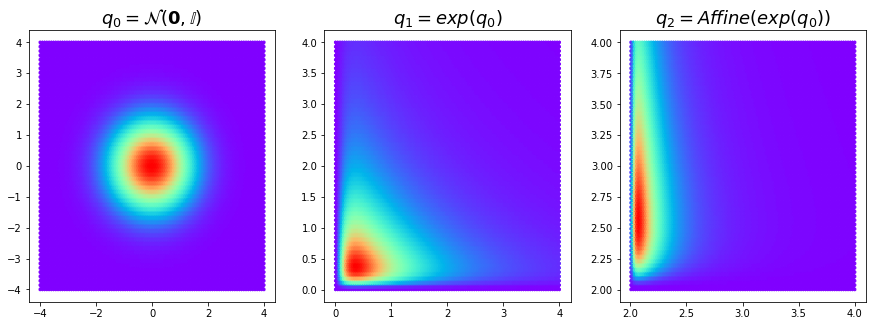

In [2]:
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
# Define an affine transform
f1 = transform.ExpTransform()
q1 = distrib.TransformedDistribution(q0, f1)
# Define an additional transform
f2 = transform.AffineTransform(2, torch.Tensor([0.2, 1.5]))
# Here I define on purpose q2 as a sequence of transforms on q0
q2 = distrib.TransformedDistribution(q0, [f1, f2])
# Plot all these lads
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=torch.exp(q0.log_prob(torch.Tensor(z))), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(z[:,0], z[:,1], C=torch.exp(q1.log_prob(torch.Tensor(z))), cmap='rainbow')
ax2.set_title('$q_1=exp(q_0)$', fontsize=18);
ax3.hexbin(z[:,0], z[:,1], C=torch.exp(q2.log_prob(torch.Tensor(z))), cmap='rainbow')
ax3.set_title('$q_2=Affine(exp(q_0))$', fontsize=18);

### Optimizing normalizing flows

The main interest in normalizing flows is that we could optimize the parameters of these flow in order to fit complex and rich probability distributions. In order to perform *inference*, we had to deal with the fact that the `Transform` object is not inherently parametric. To do so, we define our own `Flow` class which can be seen both as a `Transform` and also a `Module`that can be optmized

In [3]:
class Flow(transform.Transform, nn.Module):
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

Based on this simple *optimizable transform*, we implemented the *planar flow* proposed in the original paper by Rezende [1], which is defined as a function of the form

   $$
   f(\mathbf{z})=\mathbf{z}+\mathbf{u}h(\mathbf{w}^T\mathbf{z}+b)
   \tag{4}
   $$

   and where the determinant of the Jacobian can be obtained through

$$
\psi(\mathbf{z})=h'(\mathbf{w}^T\mathbf{z}+b)\mathbf{w}
\tag{5}
$$

$$
\left|\text{det}\frac{\delta f}{\delta\mathbf{z}}\right| = \left|\text{det}\left(\mathbf{I}+\mathbf{u}\psi(\mathbf{z})^{T}\right)\right|=\left|1+\mathbf{u}^T\psi(\mathbf{z})\right|
\tag{6}
$$

This led to our first implementation of the `PlanarFlow`. Note here that we added a little bonus that we can change the non-linearity `h` used in the flow directly in its initialization (whereas before, we directly used $h(.)=tanh(.)$)

In [4]:
class PlanarFlow(Flow):

    def __init__(self, dim, h=torch.tanh, hp=(lambda x: 1 - torch.tanh(x) ** 2)):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.h = h
        self.hp = hp
        self.init_parameters()

    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * self.h(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = self.hp(f_z) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)

We discussed the fact that the `PlanarFlow` is not invertible in all regions of the space, but we are still able to access to the transformed density by explicitly performing the change of variable.

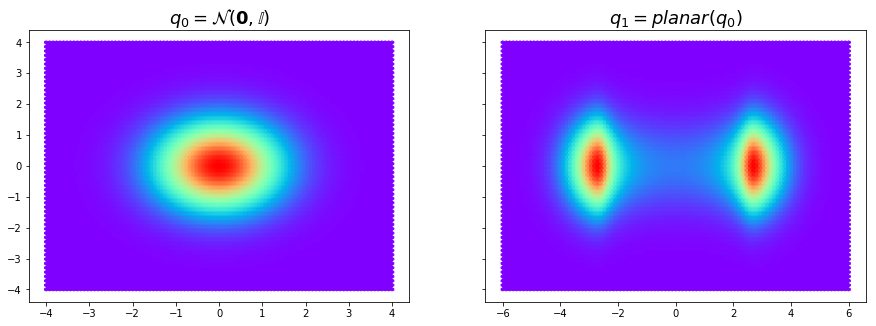

In [5]:
def change_density(q0_density, flow, z):
    # Apply our transform on coordinates
    f_z = flow(torch.Tensor(z)).detach()
    # Obtain our density
    q1_density = q0_density.squeeze() / np.exp(flow.log_abs_det_jacobian(torch.Tensor(z)).detach().squeeze())
    return q1_density, f_z

# Our base density
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
# Our transform
flow = PlanarFlow(2) 
# Manually set the transform parameters (I know it is dirty ^^)
flow.weight.data = torch.Tensor([[4, 0]])
flow.scale.data = torch.Tensor([[2, 0]])
flow.bias.data = torch.Tensor([0])
q1_density, f_z = change_density(q0_density, flow, z)
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);

<a id="recap"></a>
# Radial flow

We will start our tour of different types of flows recently introduced by re-implementing the *radial flow*, proposed in the original paper by Rezende [1]. This family of transformations aim to modify the initial density $q_0$ around a reference point $\mathbf{z}_0$

   $$
   f(\mathbf{z})=\mathbf{z}+\beta h(\alpha,r)(\mathbf{z}-\mathbf{z}_0)
   \tag{7}
   $$

   where $\beta$ is a scalar, $\alpha$ is a positive scalar $r=\left\lVert\mathbf{z}-\mathbf{z}_0\right\rVert$ and $h(\alpha,r)=1/(\alpha+r)$. As recalled in the beginning of the tutorial, in order to obtain the actual density of $f(\mathbf{z})$, we need to compute the determinant of the Jacobian $\left|\det\frac{\partial f}{\partial \mathbf{z}}\right|$. This can be computed as follows (the full derivation once again relies on the matrix determinant lemma, for a full 

$$
\left|\det\frac{\partial f}{\partial \mathbf{z}}\right| = \left(1 + \beta h(\alpha,r) + \beta h'(\alpha,r)r\right)(1+\beta h(\alpha,r))^{d-1}
\tag{8}
$$
   
This type of flow also provides a computation of the determinant in $O(D)$, but applies radial contractions and expansions around the reference point (hence the name *radial
flows*). Here, we will implement the `RadialFlow` by following our previously defined `Flow` class

In [6]:
class RadialFlow(Flow):

    def __init__(self, dim):
        super(RadialFlow, self).__init__()
        self.z0 = nn.Parameter(torch.Tensor(1, dim))
        self.alpha = nn.Parameter(torch.Tensor(1))
        self.beta = nn.Parameter(torch.Tensor(1))
        self.dim = dim
        self.init_parameters()

    def _call(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        return z + (self.beta * h * (z - self.z0))

    def log_abs_det_jacobian(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        hp = - 1 / (self.alpha + r) ** 2
        bh = self.beta * h
        det_grad = ((1 + bh) ** self.dim - 1) * (1 + bh + self.beta * hp * r)
        return torch.log(det_grad.abs() + 1e-9)

Similarily to the planar flows, these transforms are only invertible in some regions of the space based on conditions on their parameters (defined in appendix of [1]). However, we can still reparametrize these flow as before.

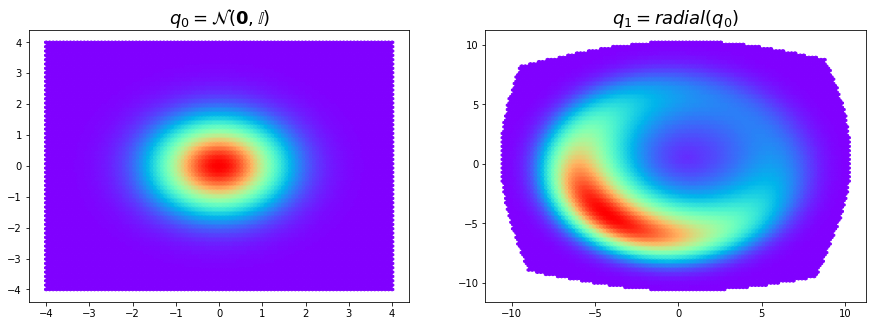

In [7]:
# Our base density
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
# Our transform
flow = RadialFlow(2) 
# Manually set the transform parameters (I know it is dirty ^^)
flow.z0.data = torch.Tensor([[0.5, 0.5]])
flow.alpha.data = torch.Tensor([1])
flow.beta.data = torch.Tensor([8])
q1_density, f_z = change_density(q0_density, flow, z)
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=radial(q_0)$', fontsize=18);

You can play around with the parameters (most notably `alpha` and `beta`) to better grasp the effect of this flow

# Invertible generative flows

Up until now, we discussed some simple transforms that could be applied based on the *change of variable* theorem for probability distributions. Now how these transform are chosen and how we could develop our own transform ? We saw that the major properties that we were looking for were that
1. the determinant of their Jacobian can be computed in linear time
2. the transformation is invertible (under usually mild conditions only)

So in fact, we can access a wide range of transforms type to use as flows, as long as these provide us with a simple determinant of their Jacobian. Hence, it can be useful to look at some of the properties of the matrix determinant itself.

A very important simplification property of the determinant is that if a matrix $\mathbf{A}\in\mathbb{R}^{D\times D}$ is triangular $a_{ij}=0$ if $j>i$, then its determinant is simply the product of its diagonal elements

$$
\text{det}\left(\mathbf{A}\right)=\prod_{i=1}^{D}a_{ii}
$$

This implies that if we find transformations whose Jacobian $\frac{\partial f}{\partial \mathbf{z}}$ is a *triangular matrix*, then their log-determinant is simply

$$
  \text{log }\left|\det{\frac{\partial f}{\partial \mathbf{z}}}\right| = \sum_{i=1}^D \text{log }\left|diag\left(\frac{\partial f}{\partial \mathbf{z}}\right)\right|
$$

This property is particularily interesting in our case. Indeed, a lot of operations performed in learning are actually *element-wise* transforms. In the cases where an operation is purely element-wise, the Jacobian of this transform is diagonal (and therefore triangular). If you need confirmation of this property, we can simply look at the complete Jacobian matrix for the application of a given element-wise operation $f(\mathbf{x})$ with $\mathbf{x}\in\mathbb{R}^{D}$

$$
\frac{\partial f(\mathbf{x})}{\partial \mathbf{x}}  = \begin{bmatrix}
\frac{\partial}{\partial x_1} ( f_1(\mathbf{x}) ) & \frac{\partial}{\partial x_2} ( f_1(\mathbf{x}) ) & \ldots & \frac{\partial}{\partial x_D} ( f_1(\mathbf{x}) )\\
\frac{\partial}{\partial x_1} ( f_2(\mathbf{x}) ) & \frac{\partial}{\partial x_2} ( f_2(\mathbf{x}) ) & \ldots & \frac{\partial}{\partial x_D} ( f_2(\mathbf{x}) )\\
& \ldots\\
\frac{\partial}{\partial x_1} ( f_D(\mathbf{x}) ) & \frac{\partial}{\partial x_2} ( f_D(\mathbf{x}) ) & \ldots & \frac{\partial}{\partial x_D} ( f_D(\mathbf{x}) )\\
\end{bmatrix}
$$

Of course, here if $f_1(\mathbf{x})$ only depends on $x_1$ (and no other component of $\mathbf{x}$), then we have $\frac{\partial}{\partial x_i} ( f_j(\mathbf{x}) ) = 0$ if $i\neq j$. Therefore, the Jacobian of element-wise operations simplifies to


$$
\frac{\partial f(\mathbf{x})}{\partial \mathbf{x}}  = \begin{bmatrix}
\frac{\partial}{\partial x_1} ( f(x_1) ) & 0 & \ldots & 0\\
0 & \frac{\partial}{\partial x_2} ( f(x_2) ) & \ldots & 0\\
& \ldots\\
0 & 0 & \ldots & \frac{\partial}{\partial x_D} ( f(x_D) )\\
\end{bmatrix}
$$

And, given the properties of the determinant of triangular matrix, we know that the determinant of the Jacobian of element-wise operations is simply

$$
  \text{log }\left|\det{\frac{\partial f}{\partial \mathbf{x}}}\right| = \sum_{i=1}^D \text{log }\left|\frac{\partial f(x_i)}{\partial x_i}\right|
$$

This is very interesting as a lot of operations such as *non-linear activation functions* are actually element-wise transforms. Therefore, we might start to look at transforms such as *Sigmoid* and *ReLUs* as flows.

### ReLU flow

One of the most pervasive activation functions in modern deep learning is the infamous Rectified Linear Unit (ReLU), which is defined by the operation $f(\mathbf{x}) = \text{max}\left(0, \mathbf{x}\right)$. Although this unit is very efficient in most applications, it is not invertible when $x < 0$.

#### Parametric ReLU flow

Now a slightly moree convienient way of defining a rectifying non-linearity in our case is to rely on the Parametric ReLU (PReLU) activation. Although this is very similar to the base ReLU (and is more generally a form of Leaky ReLU), it comes with the added bonus of having a trainable parameters. The PReLU is defined as

$$
\text{PReLU}\left(x\right)=
\begin{cases}
    x,& \text{if } x > 0\\
    \alpha . x,              & \text{otherwise}
\end{cases}
$$

The first advantage of this non-linearity is that its derivative is extremely simple. And as we have just seen for element-wise operations, we can obtain the log-determinant of its Jacobian simply as

$$
\text{log }\left|\det{\frac{\partial f}{\partial \mathbf{x}}}\right| = \sum_{i=1}^D \text{log }\left|
\begin{cases}
    1,& \text{if } x > 0\\
    \alpha ,              & \text{otherwise}
\end{cases}
\right|
$$

The second advantage of the PReLU is that it is now also invertible and we can define

$$
\text{PReLU}^{-1}\left(x\right)=
\begin{cases}
    x,& \text{if } x > 0\\
    \frac{1}{\alpha} . x,              & \text{otherwise}
\end{cases}
$$

Hence, we have all the elements to consider this transform as a flow, and we define here the `PReLUFlow` following our base architecture.

In [8]:
# Flow version of Leaky ReLU
class PReLUFlow(Flow):
    def __init__(self, dim):
        super(PReLUFlow, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor([1]))
        self.bijective = True

    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(0.01, 0.99)

    def _call(self, z):
        return torch.where(z >= 0, z, torch.abs(self.alpha) * z)

    def _inverse(self, z):
        return torch.where(z >= 0, z, torch.abs(1. / self.alpha) * z)

    def log_abs_det_jacobian(self, z):
        I = torch.ones_like(z)
        J = torch.where(z >= 0, I, self.alpha * I)
        log_abs_det = torch.log(torch.abs(J) + 1e-5)
        return torch.sum(log_abs_det, dim = 1)

tensor([1.2994e-08, 1.3393e-08, 1.3805e-08,  ..., 4.9500e-09, 4.8003e-09,
        4.6549e-09])
tensor([[-4.3530, -4.3530],
        [-4.3459, -4.3553],
        [-4.3387, -4.3575],
        ...,
        [ 8.8628,  8.8962],
        [ 8.8757,  8.8924],
        [ 8.8887,  8.8887]])


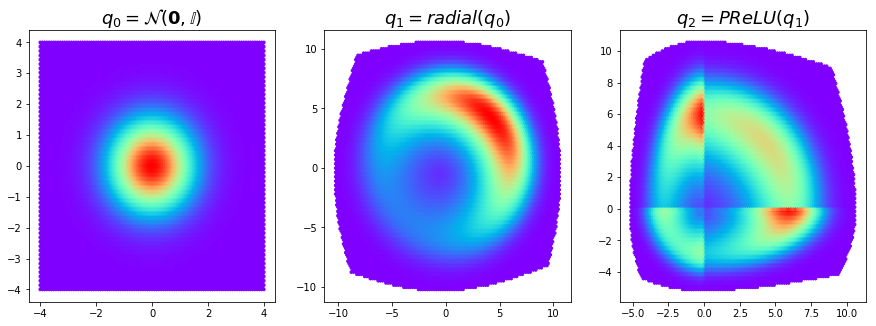

In [9]:
# Our base density
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
# Our radial transform
flow = RadialFlow(2) 
# Manually set the transform parameters (I know it is dirty ^^)
flow.z0.data = torch.Tensor([[-0.5, -0.5]])
flow.alpha.data = torch.Tensor([1])
flow.beta.data = torch.Tensor([8])
q1_density, f_z = change_density(q0_density, flow, z)
# Our ReLU flow
flow = PReLUFlow(2) 
# Manually set the transform parameters (dirty again ^^)
flow.alpha.data = torch.Tensor([0.5])
q2_density, f_z2 = change_density(q1_density, flow, f_z)
print(q2_density)
print(f_z2)
# Plot this
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=radial(q_0)$', fontsize=18);
ax3.hexbin(f_z2[:,0], f_z2[:,1], C=q2_density.numpy().squeeze(), cmap='rainbow')
ax3.set_title('$q_2=PReLU(q_1)$', fontsize=18);

### Batch Normalization

Now we are getting ahead of ourselves and we will be discussing the flow version of the *Batch Normalization* proposed in the RealNVP [2] paper (note that the full RealNVP idea and corresponding flows will be detailed in a subsequent tutorial around autoregressive flows). However, batch normalization can also be seen as a form of element-wise operation if we reparametrize it adequately (as we change the statistics of each element separately). we show here that this central piece of the deep learning machinery can also be easily translated into the world of normalizing flows. We recall that the *batch normalization* operation is defined as

$$
\begin{align}
\hat{\mathbf{x}_b} &= \frac{\mathbf{x}_b-\tilde{\mu_b}}{\sqrt{\tilde{\sigma_b}^2 + \epsilon}}\\
f\left(\mathbf{x}\right) &=\gamma\hat{\mathbf{x}_b}+\beta
\end{align}
$$

where $\mathbf{x}_b$ is one batch of data, $\tilde{\mu_b}=\mathbb{E}\left[\mathbf{x}_b\right]$ and $\tilde{\sigma_b}^2=Var\left[\mathbf{x}_b\right]$ are this batch mean and variance, and $\gamma$ and $\beta$ are two trainable parameters representing shift and scale. Now, if we reparametrize this (considering that $\tilde{\mu_b}$ and $\tilde{\sigma_b}$ are given batch statistics), we can very simply define the inverse function as

$$
\begin{align}
\tilde{\mathbf{x}_b} &= \frac{\mathbf{x}_b - \beta}{\gamma}\\
f^{-1}\left(\mathbf{x}_b\right) &= \tilde{\mathbf{x}_b} * \sqrt{\tilde{\sigma_b}^2 + \epsilon} + \tilde{\mu_b}
\end{align}
$$

Now, regarding the Jacobian determinant of the transform, we still consider the reparametrization and know that we have a very simple derivative for this operation $\frac{\partial f}{\partial x_i}=\frac{\gamma_i}{\sqrt{\tilde{\sigma_i}^2 + \epsilon}}$. Hence, as we see this as an element-wise operation, we can obtain the overall log determinant of the jacobian as

$$
\text{log }\left|\det{\frac{\partial f}{\partial \mathbf{x}}}\right| = \sum_{i=1}^D \left[ \text{log }\left(\gamma_i\right) - \frac{1}{2}\text{log }\left(\tilde{\sigma_i}^2 + \epsilon\right) \right]
$$

Therefore, we have everything to define our own `BatchNormFlow` as in the following

In [10]:
class BatchNormFlow(Flow):

    def __init__(self, dim, momentum=0.95, eps=1e-5):
        super(BatchNormFlow, self).__init__()
        # Running batch statistics
        self.r_mean = torch.zeros(dim)
        self.r_var = torch.ones(dim)
        # Momentum
        self.momentum = momentum
        self.eps = eps
        # Trainable scale and shift (cf. original paper)
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        
    def _call(self, z):
        if self.training:
            # Current batch stats
            self.b_mean = z.mean(0)
            self.b_var = (z - self.b_mean).pow(2).mean(0) + self.eps
            # Running mean and var
            self.r_mean = self.momentum * self.r_mean + ((1 - self.momentum) * self.b_mean)
            self.r_var = self.momentum * self.r_var + ((1 - self.momentum) * self.b_var)
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - mean) / var.sqrt()
        y = self.gamma * x_hat + self.beta
        return y

    def _inverse(self, x):
        if self.training:
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - self.beta) / self.gamma
        y = x_hat * var.sqrt() + mean
        return y
        
    def log_abs_det_jacobian(self, z):
        # Here we only need the variance
        mean = z.mean(0)
        var = (z - mean).pow(2).mean(0) + self.eps
        log_det = torch.log(self.gamma) - 0.5 * torch.log(var + self.eps)
        return torch.sum(log_det, -1)

### Affine transforms

Although an affine transform seems like a very simple and usual operation in machine learning, this becomes a lot more complex when trying to define it as a flow. First, recall that the determinant *only exists for square matrices*, so it seems that we are bound to apply affine transforms that *do not change the dimensionality* of the input. Second, an affine transform is clearly not an element-wise operation, so we cannot rely on the neat property of triangular Jacobians as is. Finally, we could still compute the determinant of a $D\times D$ matrix $\mathbf{A}$

$$
\text{det}\left(\mathbf{A}\right)  = \begin{bmatrix}
a_{11} & a_{12} & \ldots & a_{1D}\\
a_{11} & a_{11} & \ldots & a_{11}\\
& \ldots\\
a_{11} & a_{11} & \ldots & a_{11}\\
\end{bmatrix} = \sum_{j_1,j_2,\ldots,j_n}\left(-1\right)^{\pi\left(j_1,j_2,\ldots,j_n\right)}a_{1j_1}a_{2j_2}\ldots a_{nj_n}
$$

where $\pi(\cdot)$ define all permutations between the elements in the set $\{j_1,j_2,\dots,j_n\}$. However, this amounts to $ n!$ elements and the worst case computation of the determinant of a square matrix is $O(D^3)$. Therefore, this will become unsustainable when the dimensionality of our densities will become large. Nevertheless, PyTorch provides us with the very neat `torch.slogdet` function to compute this, so we can very easily define the `AffineFlow` which performs a flow version of the affine transform

In [11]:
## Flow version of affine transform
class AffineFlow(Flow):
    def __init__(self, dim):
        super(AffineFlow, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(dim, dim))
        nn.init.orthogonal_(self.weights)

    def _call(self, z):
        return z @ self.weights
    
    def _inverse(self, z):
        return z @ torch.inverse(self.weights)

    def log_abs_det_jacobian(self, z):
        return torch.slogdet(self.weights)[-1].unsqueeze(0).repeat(z.size(0), 1)

However, there is a way more efficient way of computing the determinant, as proposed in GLOW [5]. The cost of computing $det(\mathbf{A})$ can be reduced from $O(D^3)$ to $ O(D)$, by parametrizing the matrix $\mathbf{A}$ directly in its LU decomposition, so that

$$
\mathbf{A} = \mathbf{P} \mathbf{L} \left( \mathbf{U} + \text{diag}(\mathbf{s}) \right)
$$

where $\mathbf{P}$ is a permutation matrix, $\mathbf{L}$ is a lower triangular matrix with ones on the diagonal, $\mathbf{U}$ is an upper triangular matrix with zeros on the diagonal, and $\mathbf{s}$ is a vector. Then, the log-determinant simply becomes

$$
\text{log}\left|det(\mathbf{A})\right| = \sum\text{log}\left|det(\mathbf{s})\right|
$$

This reduction in the computational cost will become essential for large $D$. To optimize the weights of $\mathbf{A}$ efficiently, the authors propose to first initialize a random matrix $\mathbf{A}$, and then computing the LUP decomposition to obtain the initial $\mathbf{P}$ (remaining fixed) and initial values of $\mathbf{L}$ and $\mathbf{U}$ and $\mathbf{s}$ (being optimized). This is implemented in the following `AffineLUFlow` class

In [12]:
from scipy import linalg as splin
## Affine Flow with LU decomposition
class AffineLUFlow(Flow):
    def __init__(self, dim):
        super(AffineLUFlow, self).__init__()
        weights = torch.Tensor(dim, dim)
        nn.init.orthogonal_(weights)
        # Compute the parametrization
        P, L, U = splin.lu(weights.numpy())
        self.P = torch.Tensor(P)
        self.L = nn.Parameter(torch.Tensor(L))
        self.U = nn.Parameter(torch.Tensor(U))
        # Need to create masks for enforcing triangular matrices
        self.mask_low = torch.tril(torch.ones(weights.size()), -1)
        self.mask_up = torch.triu(torch.ones(weights.size()), -1)
        self.I = torch.eye(weights.size(0))
        # Now compute s
        self.s = nn.Parameter(torch.Tensor(np.diag(U)))

    def _call(self, z):
        L = self.L * self.mask_low + self.I
        U = self.U * self.mask_up + torch.diag(self.s)
        weights = self.P @ L @ U
        return z @ weights
    
    def _inverse(self, z):
        L = self.L * self.mask_low + self.I
        U = self.U * self.mask_up + torch.diag(self.s)
        weights = self.P @ L @ U
        return z @ torch.inverse(self.weights)

    def log_abs_det_jacobian(self, z):
        return torch.sum(torch.log(torch.abs(self.s))).unsqueeze(0).repeat(z.size(0), 1)

# Optimizing multi-layer perceptron flow

Now that we have all the components ready to perform a flow equivalent to a multi-layer perceptron, we just have to define its structure. Here, we make a little adjustment to our previous `NormalizingFlow` class (which represents the application of a sequence of transforms), to suit this more traditional view on having layers defined as blocks of computations. Therefore, we can now define which type of blocks are going to be applied as a simple Python list of `Transform` classes.

In [13]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det

# Our MLP blocks
block_mlp = [
    AffineFlow,
    BatchNormFlow,
    PReLUFlow
]
# Create normalizing flow
flow = NormalizingFlow(dim=2, blocks=block_mlp, flow_length=8, density=distrib.MultivariateNormal(torch.zeros(2), torch.eye(2)))

Now to try out our MLP-like flow, we are going to rely on the same density as in the first tutorial.

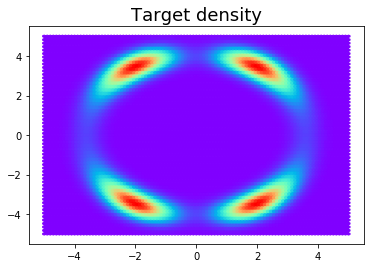

In [14]:
def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

# Plot it
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=18);

And we are also using the same loss and optimization algorithm

In [15]:
import torch.optim as optim
# Create optimizer algorithm
optimizer = optim.Adam(flow.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
# Define our loss
def loss(density, zk, log_jacobians):
    sum_of_log_jacobians = sum(log_jacobians)
    return (-sum_of_log_jacobians - torch.log(density(zk) + 1e-9)).mean()

Loss (it. 0) : 18.430624
Loss (it. 1000) : 1.782681
Loss (it. 2000) : 1.503648
Loss (it. 3000) : 1.487629
Loss (it. 4000) : 1.473531
Loss (it. 5000) : 1.341483
Loss (it. 6000) : 1.397208
Loss (it. 7000) : 1.324934
Loss (it. 8000) : 1.283700
Loss (it. 9000) : 1.142802
Loss (it. 10000) : 1.096302


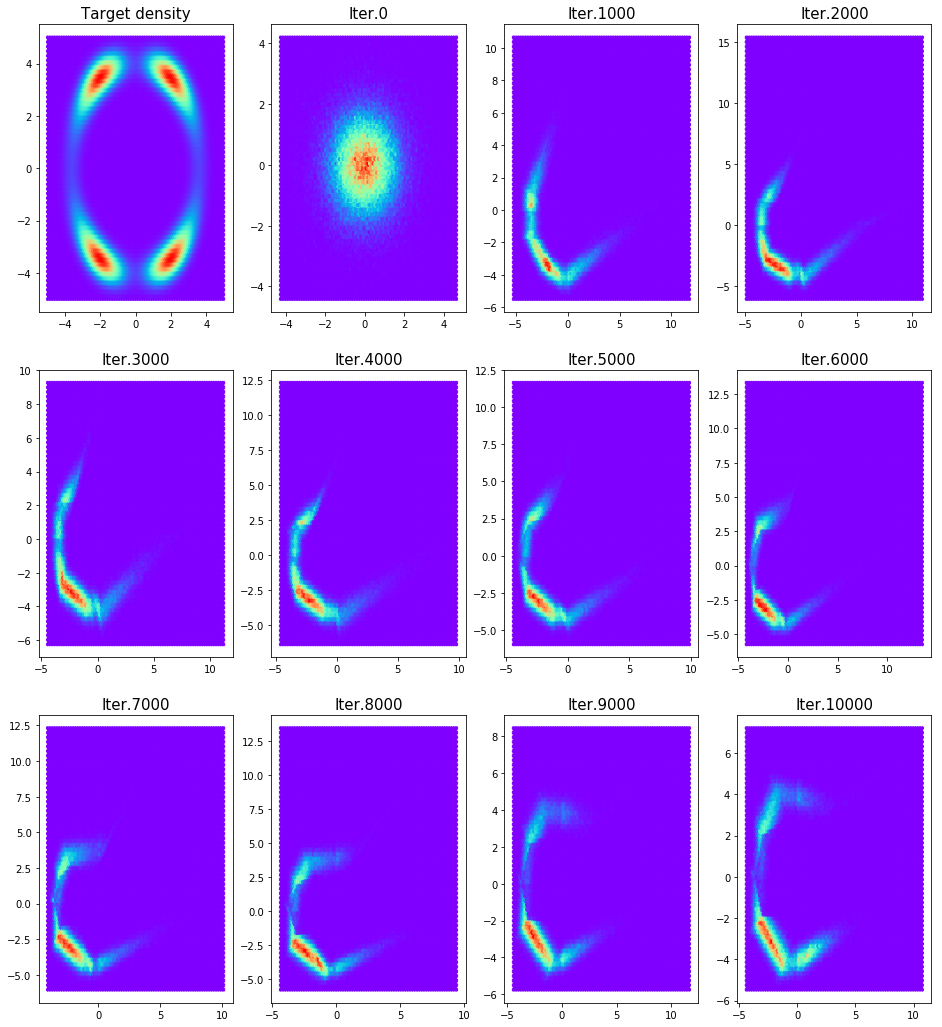

In [16]:
ref_distrib = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
id_figure=2
plt.figure(figsize=(16, 18))
plt.subplot(3,4,1)
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=15);
# Main optimization loop
for it in range(10001):
    # Draw a sample batch from Normal
    samples = ref_distrib.sample((512, ))
    # Evaluate flow of transforms
    zk, log_jacobians = flow(samples)
    # Evaluate loss and backprop
    optimizer.zero_grad()
    loss_v = loss(density_ring, zk, log_jacobians)
    loss_v.backward()
    optimizer.step()
    scheduler.step()
    if (it % 1000 == 0):
        print('Loss (it. %i) : %f'%(it, loss_v.item()))
        # Draw random samples
        samples = ref_distrib.sample((int(1e5), ))
        # Evaluate flow and plot
        zk, _ = flow(samples)
        zk = zk.detach().numpy()
        plt.subplot(3,4,id_figure)
        plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
        plt.title('Iter.%i'%(it), fontsize=15);
        id_figure += 1

### References

<a id="reference1"></a>
[1] Rezende, Danilo Jimenez, and Shakir Mohamed. "Variational inference with normalizing flows." _arXiv preprint arXiv:1505.05770_ (2015). [link](http://arxiv.org/pdf/1505.05770)

[2] Dinh, L., Sohl-Dickstein, J., & Bengio, S. Density estimation using Real NVP. arXiv preprint arXiv:1605.08803. (2016). [link](https://arxiv.org/abs/1605.08803)

[3] Kingma, Diederik P., Tim Salimans, and Max Welling. "Improving Variational Inference with Inverse Autoregressive Flow." _arXiv preprint arXiv:1606.04934_ (2016). [link](https://arxiv.org/abs/1606.04934)

[4] Papamakarios, G., Pavlakou, T., & Murray, I. (2017). Masked autoregressive flow for density estimation. In Advances in Neural Information Processing Systems (pp. 2338-2347). [link](http://homepages.inf.ed.ac.uk/imurray2/pub/17maf/maf.pdf)

[5] Germain, Mathieu, et al. "Made: masked autoencoder for distribution estimation." International Conference on Machine Learning. 2015.

### Inspirations and resources

https://blog.evjang.com/2018/01/nf1.html  
https://github.com/ex4sperans/variational-inference-with-normalizing-flows  
https://akosiorek.github.io/ml/2018/04/03/norm_flows.html  
https://github.com/abdulfatir/normalizing-flows  